In [1]:
# %load funkce.py
import copy

import numpy as np
from scipy.integrate import quad


def complex_quadrature(func, a, b, lim, **kwargs):
    def real_func(x):
        return np.real(func(x))

    def imag_func(x):
        return np.imag(func(x))

    real_integral = quad(real_func, a, b, **kwargs, limit=lim)
    imag_integral = quad(imag_func, a, b, **kwargs, limit=lim)
    return real_integral[0] + 1j * imag_integral[0]


def get_outer_T(n_terms, ref_index, i_angle, wv, per, n_0):
    i_angle = np.deg2rad(i_angle)

    values = np.linspace(-n_terms, n_terms, 2 * n_terms + 1, dtype='int')
    Nz = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1), 'cfloat'))

    for x in values:
        Ny_0 = n_0 * np.sin(i_angle)
        Ny_q = Ny_0 + x * wv / per
        gamma_down = np.sqrt(ref_index ** 2 - Ny_q ** 2, dtype='cfloat')
        if (np.imag(gamma_down) != 0 and np.real(gamma_down) < 0.005):
            gamma_down = -gamma_down
        if (gamma_down == 0):
            gamma_down += 0.00000000001
        Nz[x + n_terms, x + n_terms] = gamma_down

    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))

    return np.block([[i, o, i, o], [-Nz, o, Nz, o], [o, Nz / ref_index, o, Nz / ref_index],
                     [o, i * ref_index, o, i * -ref_index]])


def get_C_matrix(period, coef_integral, n_terms):
    def fill_c(i, j):
        temp = i - j
        return np.vectorize(coef_integral)(temp)

    return np.matrix(np.fromfunction(fill_c, (2 * n_terms + 1, 2 * n_terms + 1)), 'cfloat')


def get_B_matrix(n_terms, wv, period, b0):
    def calc_b(i, j):
        if ((i - j) == 0):
            temp = i - n_terms
            return b0 + wv * temp / period
        else:
            return 0

    def fill_b(i, j):
        return np.vectorize(calc_b)(i, j)

    return np.matrix(np.fromfunction(fill_b, (2 * n_terms + 1, 2 * n_terms + 1)))


def getLayerMatrix_ordered(gamma, v, width, wv):
    down_array = []
    up_array = []
    limit_value = 0.0000000001
    it = np.nditer(gamma, flags=['f_index'])
    while not it.finished:
        if (np.abs(np.imag(it[0])) < limit_value):
            if (np.real(it[0]) < 0):
                up_array.append(it.index)
            else:
                down_array.append(it.index)
        elif (np.imag(it[0]) < 0):
            down_array.append(it.index)
        else:
            up_array.append(it.index)
        it.iternext()
    t = np.matrix(np.identity(len(gamma)), 'cfloat')
    p = np.matrix(np.identity(len(gamma), dtype='cfloat'))
    index = 0
    for x in up_array:
        t[:, index] = v[:, x]
        p[index, index] = np.exp(1j * gamma[x] * width * 2 * np.pi / wv)
        index += 1
    for x in down_array:
        t[:, index] = v[:, x]
        p[index, index] = np.exp(-1j * gamma[x] * width * 2 * np.pi / wv)
        index += 1

    if (len(down_array) != len(up_array)):
        print(down_array)
        print(up_array)
        print(gamma)
        raise Exception("Ordering of modes failed!")
    return t, p


def get_periodic_layer_T_P(period, c_matrix, n_terms, angle, wv, n_0, width):
    c = c_matrix
    b0 = n_0 * np.sin(np.deg2rad(angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block([[o, i, o, o], [c - b ** 2, o, o, o], [o, o, o, b * (c ** -1) * b - i], [o, o, -c, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_FF(period, c_matrix, c_matrix_inv, n_terms, angle, wv, n_0, width):
    c = c_matrix
    c_inv = c_matrix_inv
    b0 = n_0 * np.sin(np.deg2rad(angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(
        np.block([[o, i, o, o], [c - b ** 2, o, o, o], [o, o, o, b * (c ** -1) * b - i], [o, o, -c_inv ** -1, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_long(period, c_diag, c_mag, n_terms, angle, incidence_plane_angle, wv, n_0, width):
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[o, i, o, o], [-b ** 2 + c_diag - c_mag * c_diag ** -1 * (-c_mag), o, o, c_mag * c_diag ** -1 * b],
         [-b * c_diag ** -1 * (-c_mag), o, o, b * c_diag ** -1 * b - i], [o, o, -c_diag, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_long_FF(period, q_11, q_13, q_22, q_31, q_33, n_terms, angle, incidence_plane_angle, wv, n_0,
                                   width):
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block([[o, i, o, o], [-b ** 2 + q_11 - q_13 * q_33 ** -1 * q_31, o, o, q_13 * q_33 ** -1 * b],
                            [-b * q_33 ** -1 * q_31, o, o, b * q_33 ** -1 * b - i], [o, o, -q_22, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_pol(period, c_diag, c_mag, n_terms, angle, incidence_plane_angle, wv, n_0, width):
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[o, i, o, o], [-b ** 2 + c_diag, o, -c_mag, o], [o, o, o, b * c_diag ** -1 * b - i], [-c_mag, o, -c_diag, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_pol_FF(period, c_diag, q_22, q_12, n_terms, angle, incidence_plane_angle, wv, n_0, width):
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[o, i, o, o], [-b ** 2 + c_diag, o, -q_12, o], [o, o, o, b * c_diag ** -1 * b - i], [-q_12, o, q_22, o]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_aniso(period, c_11, c_12, c_13, c_21, c_22, c_23, c_31, c_32, c_33, n_terms, angle,
                                 incidence_plane_angle, wv, n_0, width):
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[-a * c_33 ** -1 * c_31, i - a * c_33 ** -1 * a, -a * c_33 ** -1 * c_32, a * c_33 ** -1 * b],
         [-b ** 2 + c_11 - c_13 * c_33 ** -1 * c_31, -c_13 * c_33 ** -1 * a, b * a + c_12 - c_13 * c_33 ** -1 * c_32,
          c_13 * c_33 ** -1 * b],
         [-b * c_33 ** -1 * c_31, -b * c_33 ** -1 * a, -b * c_33 ** -1 * c_32, b * c_33 ** -1 * b - i],
         [-a * b - c_21 + c_23 * c_33 ** -1 * c_31, c_23 * c_33 ** -1 * a, a ** 2 - c_22 + c_23 * c_33 ** -1 * c_32,
          -c_23 * c_33 ** -1 * b]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p


def get_periodic_layer_T_P_aniso_new(period, toeplitz_matrix, n_terms, angle,
                                     incidence_plane_angle, wv, n_0, width):
    c_11 = toeplitz_matrix[0]
    c_12 = toeplitz_matrix[1]
    c_13 = toeplitz_matrix[2]
    c_21 = toeplitz_matrix[3]
    c_22 = toeplitz_matrix[4]
    c_23 = toeplitz_matrix[5]
    c_31 = toeplitz_matrix[6]
    c_32 = toeplitz_matrix[7]
    c_33 = toeplitz_matrix[8]
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[-a * c_33 ** -1 * c_31, i - a * c_33 ** -1 * a, -a * c_33 ** -1 * c_32, a * c_33 ** -1 * b],
         [-b ** 2 + c_11 - c_13 * c_33 ** -1 * c_31, -c_13 * c_33 ** -1 * a, b * a + c_12 - c_13 * c_33 ** -1 * c_32,
          c_13 * c_33 ** -1 * b],
         [-b * c_33 ** -1 * c_31, -b * c_33 ** -1 * a, -b * c_33 ** -1 * c_32, b * c_33 ** -1 * b - i],
         [-a * b - c_21 + c_23 * c_33 ** -1 * c_31, c_23 * c_33 ** -1 * a, a ** 2 - c_22 + c_23 * c_33 ** -1 * c_32,
          -c_23 * c_33 ** -1 * b]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return t, p

def split_matrix(c):
    division_index = int(len(c) / 2)
    c_uu = c[0:division_index, 0:division_index]
    c_ud = c[0:division_index, division_index:2 * division_index]
    c_du = c[division_index:2 * division_index, 0:division_index]
    c_dd = c[division_index:2 * division_index, division_index:2 * division_index]
    return c_uu, c_ud, c_du, c_dd


def get_s_boundary(t1, t2):
    c = t2 ** -1 * t1
    c_uu, c_ud, c_du, c_dd = split_matrix(c)
    return np.block([[c_uu ** -1, -c_uu ** -1 * c_ud], [c_du * c_uu ** -1, c_dd - c_du * c_uu ** -1 * c_ud]])


def get_s(t1, t2, p2):
    c = t2 ** -1 * t1
    c_uu, c_ud, c_du, c_dd = split_matrix(c)
    P_up, P, P, P_down = split_matrix(p2)
    return np.block([[c_uu ** -1 * P_up, -c_uu ** -1 * c_ud],
                     [P_down * c_du * c_uu ** -1 * P_up, P_down * (c_dd - c_du * c_uu ** -1 * c_ud)]])


def join_s_matrices_recur(S_0, s_1):
    division_index = int(len(S_0) / 2)
    t_uu, r_ud, r_du, t_dd = split_matrix(s_1)
    T_velke_uu, R_velke_ud, R_velke_du, T_velke_dd = split_matrix(S_0)

    T_uu = T_velke_uu * (np.identity(division_index) - r_ud * R_velke_du) ** -1 * t_uu
    R_ud = R_velke_ud + T_velke_uu * (np.identity(division_index) - r_ud * R_velke_du) ** -1 * r_ud * T_velke_dd
    R_du = r_du + t_dd * (np.identity(division_index) - R_velke_du * r_ud) ** -1 * R_velke_du * t_uu
    T_dd = t_dd * (np.identity(division_index) - R_velke_du * r_ud) ** -1 * T_velke_dd
    return np.block([[T_uu, R_ud], [R_du, T_dd]])


def join_s_matrices(S_0, s_1):
    division_index = int(len(S_0) / 2)
    t_uu, r_ud, r_du, t_dd = split_matrix(s_1)
    T_velke_uu, R_velke_ud, R_velke_du, T_velke_dd = split_matrix(S_0)

    T_uu = T_velke_uu * (np.identity(division_index) - r_ud * R_velke_du) ** -1 * t_uu
    R_ud = R_velke_ud + T_velke_uu * (np.identity(division_index) - r_ud * R_velke_du) ** -1 * r_ud * T_velke_dd
    R_du = r_du + t_dd * (np.identity(division_index) - R_velke_du * r_ud) ** -1 * R_velke_du * t_uu
    T_dd = t_dd * (np.identity(division_index) - R_velke_du * r_ud) ** -1 * T_velke_dd
    return T_uu, R_ud, R_du, T_dd


def diff_eff_coef(order, i_angle, n_0, wv, per):
    angle = np.deg2rad(i_angle)
    Ny_0 = n_0 * np.sin(angle)
    Ny_q = Ny_0 + order * wv / per
    gamma_down = np.sqrt(n_0 ** 2 - Ny_q ** 2, dtype='cfloat')
    gamma_down_0 = n_0 * np.cos(angle)
    return np.abs(np.real(gamma_down) / np.real(gamma_down_0))


def diff_eff_coef_trans(order, i_angle, n_0, n_2, wv, per):
    angle = np.deg2rad(i_angle)
    Ny_0 = n_0 * np.sin(angle)
    Ny_q = Ny_0 + order * wv / per
    gamma_down = np.sqrt(n_2 ** 2 - Ny_q ** 2, dtype='cfloat')
    gamma_down_0 = n_0 * np.cos(angle)
    return np.abs(np.real(gamma_down) / np.real(gamma_down_0))


def get_incoherent_P_iso(width, wv, n_0, i_angle, n_layer):
    angle = np.deg2rad(i_angle)
    Ny = n_0 * np.sin(angle)
    gamma_down = np.sqrt(n_layer ** 2 - Ny ** 2, dtype='cfloat')
    p = np.exp(2 * np.imag(gamma_down * 2 * np.pi / wv) * width)
    return np.matrix([[p, 0, 0, 0], [0, p, 0, 0], [0, 0, p, 0], [0, 0, 0, p]])


def select_modes(n_terms, n_select, matrix):
    if (n_terms - n_select != n_terms):
        ss = matrix[n_terms - n_select:n_terms + n_select + 1, n_terms - n_select:n_terms + n_select + 1]
        pp = matrix[2 * (n_terms + 1) + n_terms - 1 - n_select:2 * (n_terms + 1) + n_terms + n_select,
             2 * (n_terms + 1) + n_terms - 1 - n_select:2 * (n_terms + 1) + n_terms + n_select]
        sp = matrix[n_terms - n_select:n_terms + n_select + 1,
             2 * (n_terms + 1) + n_terms - 1 - n_select:2 * (n_terms + 1) + n_terms + n_select]
        ps = matrix[2 * (n_terms + 1) + n_terms - 1 - n_select:2 * (n_terms + 1) + n_terms + n_select,
             n_terms - n_select:n_terms + n_select + 1]
    else:
        ss = matrix[n_terms, n_terms]
        pp = matrix[3 * n_terms + 1, 3 * n_terms + 1]
        sp = matrix[n_terms, 3 * n_terms + 1]
        ps = matrix[3 * n_terms + 1, n_terms]

    return np.block([[ss, sp], [ps, pp]])


def get_order_coh_matrix(coh_reflektance, n_terms, order):
    coh_matrix_11 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (n_terms + order), (n_terms) * 2 * (2 * n_terms + 1) + (n_terms)]
    coh_matrix_12 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (n_terms + order), (n_terms) * 2 * (2 * n_terms + 1) + (
                    3 * n_terms + 1)]
    coh_matrix_21 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (3 * n_terms + 1 + order), (n_terms) * 2 * (2 * n_terms + 1) + (
            n_terms)]
    coh_matrix_22 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (3 * n_terms + 1 + order), (n_terms) * 2 * (2 * n_terms + 1) + (
                    3 * n_terms + 1)]
    coh_matrix_13 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (n_terms + order), (4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (
                    2 * n_terms + 1) - (3 * n_terms) - 1]
    coh_matrix_14 = coh_reflektance[
        (n_terms + order) * 2 * (2 * n_terms + 1) + (n_terms + order), (4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (
                    2 * n_terms + 1) - n_terms]
    coh_matrix_23 = coh_reflektance[(n_terms + order) * 2 * (2 * n_terms + 1) + (3 * n_terms + 1 + order), (
                4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - (3 * n_terms) - 1]
    coh_matrix_24 = coh_reflektance[(n_terms + order) * 2 * (2 * n_terms + 1) + (3 * n_terms + 1 + order), (
                4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - n_terms]

    coh_matrix_31 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (3 * n_terms - order + 1), (
            n_terms) * 2 * (2 * n_terms + 1) + (n_terms)]
    coh_matrix_32 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (3 * n_terms - order + 1), (
            n_terms) * 2 * (2 * n_terms + 1) + (3 * n_terms + 1)]
    coh_matrix_41 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (n_terms - order), (n_terms) * 2 * (
                    2 * n_terms + 1) + (n_terms)]
    coh_matrix_42 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (n_terms - order), (n_terms) * 2 * (
                    2 * n_terms + 1) + (3 * n_terms + 1)]

    coh_matrix_33 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (3 * n_terms - order + 1), (
                    4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - (3 * n_terms) - 1]
    coh_matrix_34 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (3 * n_terms - order + 1), (
                    4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - n_terms]
    coh_matrix_43 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (n_terms - order), (
                    4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - 3 * n_terms - 1]
    coh_matrix_44 = coh_reflektance[
        (4 * n_terms + 2) ** 2 - 1 - (n_terms - order) * 2 * (2 * n_terms + 1) - (n_terms - order), (
                    4 * n_terms + 2) ** 2 - 1 - n_terms * 2 * (2 * n_terms + 1) - n_terms]
    return np.matrix([[coh_matrix_11, coh_matrix_12, coh_matrix_13, coh_matrix_14],
                      [coh_matrix_21, coh_matrix_22, coh_matrix_23, coh_matrix_24],
                      [coh_matrix_31, coh_matrix_32, coh_matrix_33, coh_matrix_34],
                      [coh_matrix_41, coh_matrix_42, coh_matrix_43, coh_matrix_44]])


def get_prop_matrix(per, angle, n_1, n_0, n_terms, width, wv):
    Ny_0 = n_0 * np.sin(np.deg2rad(angle))

    def fill_prop_matrix(i, j):
        if (i == j):
            if (i < (2 * n_terms + 1)):
                n = i - n_terms
            else:
                n = i - 3 * n_terms - 1
            Ny_q = Ny_0 + n * wv / per
            gamma = np.sqrt(n_1 ** 2 - Ny_q ** 2, dtype='cfloat')
            gamma = np.real(gamma) - 1j * np.abs(np.imag(gamma))
            return np.exp(-1j * gamma * 2 * np.pi / wv * width)
        return 0

    return np.matrix(np.fromfunction(np.vectorize(fill_prop_matrix), (2 * (2 * n_terms + 1), 2 * (2 * n_terms + 1))),
                     'cfloat')


# Modifikace propagační matice, aby vyhodila nesmyslné členy
def prop_trans(n_terms):
    list = []
    add_choice = 0
    add = 1
    n = 2 * n_terms + 1
    cursor = 0
    for x in range((4 * n_terms + 2) ** 2):
        if (x == cursor):
            list.append(x)
            if (add_choice == 0):
                cursor += 2 * n_terms + 1
                add_choice = 1
            elif (add_choice == 1):
                if (cursor == ((4 * n_terms + 2) ** 2 / 2 - 1)):
                    cursor += 1
                    add_choice = 0
                else:
                    cursor += 2 * n_terms + 1 + add
                    add_choice = 0
    array = np.zeros(((2 * (2 * n_terms + 1)) ** 2, (2 * (2 * n_terms + 1)) ** 2))
    for x in list:
        array[x, x] = 1
    return array


# FF implementace pro n materiálů v periodické struktuře
def get_Q_matrix_periodic(materials, period, n_terms):
    def q_cap_ref1_integral(x):
        def integrand_function(y):
            for item in materials:
                if ((item['start'] * period) <= y and y <= (item['stop'] * period)):
                    return item['permittivity'][0] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_cap_ref1 = get_C_matrix(period, q_cap_ref1_integral, n_terms)

    def q_ref_grating3_integral(x):
        def integrand_function(y):
            for item in materials:
                if ((item['start'] * period) <= y and y <= (item['stop'] * period)):
                    return item['permittivity'][8] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_ref_grating3 = get_C_matrix(period, q_ref_grating3_integral, n_terms)

    def q_cap_grating2_integral(x):
        def integrand_function(y):
            for item in materials:
                if ((item['start'] * period) <= y and y <= (item['stop'] * period)):
                    return 1 / item['permittivity'][4] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_cap_grating2 = get_C_matrix(period, q_cap_grating2_integral, n_terms) ** -1

    def q_0_integral(x):
        def integrand_function(y):
            return 0 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_0 = get_C_matrix(period, q_0_integral, n_terms)

    return q_cap_ref1, q_0, q_0, q_0, q_cap_grating2, q_0, q_0, q_0, q_ref_grating3


# FF implementace pro neperiodické vrstvy
def get_Q_matrix_non_periodic(perm, period, n_terms):
    e_11 = perm[0]
    e_12 = perm[1]
    e_13 = perm[2]
    e_21 = perm[3]
    e_22 = perm[4]
    e_23 = perm[5]
    e_31 = perm[6]
    e_32 = perm[7]
    e_33 = perm[8]
    fill_factor = 1
    quarature_terms = 100

    def q_22_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return 1 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_22 = get_C_matrix(period, q_22_integral, n_terms) ** -1

    def q_12_integral(x):
        if (e_12 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_12 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_12 = get_C_matrix(period, q_12_integral, n_terms) * q_22

    def q_21_integral(x):
        if (e_21 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_21 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_21 = q_22 * get_C_matrix(period, q_21_integral, n_terms)

    def q_23_integral(x):
        if (e_23 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_23 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_23 = q_22 * get_C_matrix(period, q_23_integral, n_terms)

    def q_32_integral(x):
        if (e_32 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_32 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_32 = get_C_matrix(period, q_32_integral, n_terms) * q_22

    def q_11_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_11 - e_12 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_11 = get_C_matrix(period, q_11_integral, n_terms) + q_12 * get_C_matrix(period, q_21_integral, n_terms)

    def q_33_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_33 - e_32 * e_23 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_33 = get_C_matrix(period, q_33_integral, n_terms) + q_32 * get_C_matrix(period, q_23_integral, n_terms)

    def q_13_integral(x):
        if (e_13 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_13 - e_21 * e_23 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_13 = get_C_matrix(period, q_13_integral, n_terms) + q_12 * get_C_matrix(period, q_23_integral, n_terms)

    def q_31_integral(x):
        if (e_31 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_31 - e_32 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, quarature_terms))

    q_31 = get_C_matrix(period, q_31_integral, n_terms) + q_32 * get_C_matrix(period, q_21_integral, n_terms)

    return q_11, q_12, q_13, q_21, q_22, q_23, q_31, q_32, q_33


# Z dané struktury vypočítá pole toeplizových matic
def calculate_toeplitz_matrices(structure, options):
    layer_toeplitz_matrices = []

    perm = [structure['superstrate'] ** 2, 0, 0, 0, structure['superstrate'] ** 2, 0, 0, 0,
            structure['superstrate'] ** 2]
    layer_toeplitz_matrices.append(get_Q_matrix_non_periodic(perm, structure['period'], options['n_terms']))

    for x in structure['data']:
        if not x.get('periodic'):
            layer_toeplitz_matrices.append(
                get_Q_matrix_non_periodic(x['permittivity'], structure['period'], options['n_terms']))
        elif x['periodic']:
            layer_toeplitz_matrices.append(
                get_Q_matrix_periodic(x['materials'], structure['period'], options['n_terms']))

    perm = np.array(
        [structure['substrate'] ** 2, 0, 0, 0, structure['substrate'] ** 2, 0, 0, 0, structure['substrate'] ** 2])
    layer_toeplitz_matrices.append(get_Q_matrix_non_periodic(perm, structure['period'], options['n_terms']))

    return layer_toeplitz_matrices


# Z dané struktury vypočítá celkovou s-matici soustavy, pole toeplizových matic se může buď dodat zvenčí nebo ne,
# pokud nás zajímá závislost na parametru struktury
def calculate_s_matrix(structure, options, layer_toeplitz_matrices=[]):
    layer_eigen_matrices = []
    s_matrices = []

    if not structure.get('top_superstrate'):
        structure['top_superstrate'] = structure['superstrate']

    if len(layer_toeplitz_matrices) == 0:
        layer_toeplitz_matrices = calculate_toeplitz_matrices(structure, options)

    for index, item in enumerate(layer_toeplitz_matrices):
        if index == 0:
            layer_eigen_matrices.append(
                {'polarisation': get_outer_T(options['n_terms'], structure['superstrate'], options['angle'],
                                             options['wavelength'], structure['period'], structure['top_superstrate'])})
        elif index == (len(layer_toeplitz_matrices) - 1):
            layer_eigen_matrices.append(
                {'polarisation': get_outer_T(options['n_terms'], structure['substrate'], options['angle'],
                                             options['wavelength'], structure['period'], structure['top_superstrate'])})
        else:
            polarisation, propagation = get_periodic_layer_T_P_aniso_new(structure['period'], item, options['n_terms'],
                                                                         options['angle'], 0,
                                                                         options['wavelength'],
                                                                         structure['top_superstrate'],
                                                                         structure['data'][index - 1]['width'])
            layer_eigen_matrices.append({'polarisation': polarisation, 'propagation': propagation})

    for index, item in enumerate(layer_eigen_matrices):
        if index == (len(layer_eigen_matrices) - 2):
            s_matrices.append(get_s_boundary(item['polarisation'], layer_eigen_matrices[index + 1]['polarisation']))
        elif index == (len(layer_eigen_matrices) - 1):
            continue
        else:
            s_matrices.append(get_s(item['polarisation'], layer_eigen_matrices[index + 1]['polarisation'],
                                    layer_eigen_matrices[index + 1]['propagation']))

    s_matrix = np.array([])
    for index, item in enumerate(s_matrices):
        if len(s_matrices) == 1:
            s_matrix = item
        elif index == (len(s_matrices) - 1):
            continue
        elif index == 0:
            s_matrix = join_s_matrices_recur(item, s_matrices[index + 1])
        else:
            s_matrix = join_s_matrices_recur(s_matrix, s_matrices[index + 1])

    return s_matrix


# Rozdělí danou strukturu na koherentní podstruktury
def get_coherent_subsets(structure):
    coherent_subsystems = []
    temp_structure = {
        'top_superstrate': structure['superstrate'],
        'superstrate': structure['superstrate'],
        'period': structure['period'],
        'data': []
    }
    for item in structure['data']:
        if item['coherent']:
            temp_structure['data'].append(item)
        else:
            temp_structure['substrate'] = np.sqrt(item['permittivity'][0])
            temp_structure['width_below_incoherent'] = item['width']
            coherent_subsystems.append(copy.deepcopy(temp_structure))
            temp_structure = {
                'top_superstrate': structure['superstrate'],
                'period': structure['period'],
                'superstrate': np.sqrt(item['permittivity'][0]),
                'data': []
            }
    temp_structure['substrate'] = structure['substrate']
    coherent_subsystems.append(temp_structure)
    return coherent_subsystems


# Rekurentně spojí podsoustavy - aplikace Partial waves alg.

def calculate_incoherent_partial_waves(coherent_subsystems, options):
    # Ziskam matice koeficientu z první s-matice
    T_uu, R_ud, R_du, T_dd = split_matrix(coherent_subsystems[0]['s_matrix'])
    r_01, t_01, r_10, t_10 = select_modes(options['n_terms'], options['n_select'], R_ud), select_modes(
        options['n_terms'], options['n_select'], T_dd), select_modes(
        options['n_terms'], options['n_select'], R_du), select_modes(options['n_terms'], options['n_select'], T_uu)
    cr_01 = np.kron(r_01, np.conj(r_01))
    ct_01 = np.kron(t_01, np.conj(t_01))
    cr_10 = np.kron(r_10, np.conj(r_10))
    ct_10 = np.kron(t_10, np.conj(t_10))

    # Rekurentni smycka
    for x in range(len(coherent_subsystems) - 1):
        # Ziskam matice koeficientu z n-té s-matice
        T_uu, R_ud, R_du, T_dd = split_matrix(coherent_subsystems[x + 1]['s_matrix'])

        # Vyberu danyc pocet modu
        r_12, t_12, r_21, t_21 = select_modes(options['n_terms'], options['n_select'], R_ud), select_modes(
            options['n_terms'], options['n_select'], T_dd), select_modes(
            options['n_terms'], options['n_select'], R_du), select_modes(options['n_terms'], options['n_select'], T_uu)

        # Propagační matice pro každý mód
        p_13 = get_prop_matrix(coherent_subsystems[x]['period'], options['angle'], coherent_subsystems[x]['substrate'],
                               coherent_subsystems[x]['top_superstrate'], options['n_select'],
                               coherent_subsystems[x]['width_below_incoherent'], options['wavelength'])
        p_24 = get_prop_matrix(coherent_subsystems[x]['period'], options['angle'], coherent_subsystems[x]['substrate'],
                               coherent_subsystems[x]['top_superstrate'], options['n_select'],
                               coherent_subsystems[x]['width_below_incoherent'], options['wavelength'])

        # Tvorba koherenčních matic
        cr_12 = np.kron(r_12, np.conj(r_12))
        ct_12 = np.kron(t_12, np.conj(t_12))
        cr_21 = np.kron(r_21, np.conj(r_21))
        ct_21 = np.kron(t_21, np.conj(t_21))

        # Aplikace transformacnich matic - vynulovani nesmyslnych clenu
        a = prop_trans(options['n_select'])

        cp_13 = np.kron(p_13, np.conj(p_13)) * a
        cp_24 = np.kron(p_24, np.conj(p_24)) * a

        # Rekurentni vzorce
        cr_01_temp = cr_01 + ct_10 * cp_24 * cr_12 * cp_13 * (
                np.matrix(np.identity(
                    (2 * (2 * options['n_select'] + 1)) ** 2)) - cr_10 * cp_24 * cr_12 * cp_13) ** -1 * ct_01
        ct_01_temp = ct_12 * cp_13 * (np.matrix(np.identity((2 * (2 * options['n_select'] + 1)) ** 2)) - cr_10 * cp_13 *
                                      cr_12 * cp_13) ** -1 * ct_01

        cr_10_temp = cr_21 + ct_12 * cp_13 * cr_10 * cp_13 * (np.matrix(np.identity(
            (2 * (2 * options['n_select'] + 1)) ** 2)) - cr_12 * cp_13 * cr_10 * cp_13) ** -1 * ct_21

        ct_10_temp = ct_10 * cp_13 * (np.matrix(np.identity((2 * (2 * options['n_select'] + 1)) ** 2)) - cr_12 * cp_13 *
                                      cr_10 * cp_13) ** -1 * ct_21

        # Prepisu prvni koeficienty novymi, rekurze
        cr_01, cr_10, ct_01, ct_10 = cr_01_temp, cr_10_temp, ct_01_temp, ct_10_temp

    return [cr_01, ct_01, cr_10, ct_10]


# Transforms returned values into - coefficients, diff_angles
def get_coeffs(values):
    coefficients = []
    diff_angles = []
    for x in values:
        coefficients.append(x['coefficients'])
        diff_angles.append(x['diff_angles'])
    return np.array(coefficients), np.array(diff_angles)


def get_diff_angle(order, angle, wv, period):
    temp = np.sin(np.deg2rad(angle)) + order * wv / period
    if ((np.rad2deg(temp) > -57.29 and np.rad2deg(temp) < 57.29) and np.rad2deg(temp) != 0):
        return np.rad2deg(np.arcsin(temp))
    elif (np.rad2deg(temp) < -57.29):
        return angle
    else:
        return angle


# Returns in the format reflectance_s , reflectance_p, transmittance_s, transmittance_p, diff_angles
def get_observables(coh_matrices, options, structure):
    reflectance_s = []
    reflectance_p = []
    transmittance_s = []
    transmittance_p = []
    diff_angles = []

    orders = None
    if options['n_select'] < 5:
        orders = options['n_select'] + 1
    else:
        orders = 5

    for x in range(orders):
        diff_angles.append(get_diff_angle(x, options['angle'], options['wavelength'], structure['period']))
        reflectance_s.append(get_order_coh_matrix(coh_matrices[0], options['n_select'], x)[0, 0] * diff_eff_coef(x, options['angle'], structure['superstrate'], options
        ['wavelength'], structure['period']))
        reflectance_p.append(get_order_coh_matrix(coh_matrices[0], options['n_select'], x)[3, 3] * diff_eff_coef(x, options['angle'], structure['superstrate'], options[
            'wavelength'], structure['period']))
        transmittance_s.append(get_order_coh_matrix(coh_matrices[1], options['n_select'], x)[0, 0] * diff_eff_coef_trans(x, options['angle'], structure['superstrate'],
                                                                                                                         structure['substrate'], options['wavelength'],
                                                                                                                         structure['period']))
        transmittance_p.append(get_order_coh_matrix(coh_matrices[1], options['n_select'], x)[3, 3] * diff_eff_coef_trans(x, options['angle'], structure['superstrate'],
                                                                                                                         structure['substrate'], options['wavelength'],
                                                                                                                         structure['period']))
        if x != 0:
            diff_angles.append(get_diff_angle(-x, options['angle'], options['wavelength'], structure['period']))
            reflectance_s.append(
                get_order_coh_matrix(coh_matrices[0], options['n_select'], -x)[0, 0] * diff_eff_coef(-x, options['angle'], structure['superstrate'], options
                ['wavelength'], structure['period']))
            reflectance_p.append(
                get_order_coh_matrix(coh_matrices[0], options['n_select'], -x)[3, 3] * diff_eff_coef(-x, options['angle'], structure['superstrate'], options[
                    'wavelength'], structure['period']))
            transmittance_s.append(
                get_order_coh_matrix(coh_matrices[1], options['n_select'], -x)[0, 0] * diff_eff_coef_trans(-x, options['angle'], structure['superstrate'],
                                                                                                           structure['substrate'], options['wavelength'],
                                                                                                           structure['period']))
            transmittance_p.append(
                get_order_coh_matrix(coh_matrices[1], options['n_select'], -x)[3, 3] * diff_eff_coef_trans(-x, options['angle'], structure['superstrate'],
                                                                                                           structure['substrate'], options['wavelength'],
                                                                                                           structure['period']))

    return reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles


# Returns values, diffraction_angles tuple, Need to supply correct structure and options defining functions
#
#
# def options_defining_func(param):
#
#     return {
#         'n_terms': 10,
#         'n_select': 3,
#         'wavelength': param,
#         'angle': 0,
#         'divisions': 100,
#         'divisions_start': 400,
#         'divisions_end': 800,
#         'dependence': {
#             'name':'wavelength', ##angle // wavelength // structure
#             'label': []
#         }
# }
#
#
# def structure_defining_func(param):
#
#     perm_ref = (-35 - 12j)
#     perm_capping = 2.25
#     param = 0.5
#
#     return {
#     'superstrate': 1,  # indexes, not perm
#     'substrate': 1.5,
#     'period': 1000,
#     'data': [
#         {'width': 2000, 'periodic': False, 'coherent': False,
#          'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping]},
#         {'width': 20, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [perm_ref, 0, 0, 0, perm_ref, 0, 0, 0, perm_ref], 'start': 0, 'stop': param},
#             {'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping], 'start': param, 'stop': 1},
#         ]},
#         {'width': 80, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [2.25, 0, 0, 0, 2.25, 0, 0, 0, 2.25], 'start': 0, 'stop': param},
#             {'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping], 'start': param, 'stop': 1},
#         ]},
#         {'width': 20, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [2.25, 0, 0, 0, 2.25, 0, 0, 0, 2.25], 'start': 0, 'stop': param},
#             {'permittivity': [perm_ref, 0, 0, 0, perm_ref, 0, 0, 0, perm_ref], 'start': param, 'stop': 1},
#         ]}
#     ]}
def general_func(structure_defining_func=None, options_defining_func=None):
    options = options_defining_func(0)
    structure = structure_defining_func(0)

    def options_func(dep_options):
        print('timer: tick', flush=True)
        for item in coherent_subsystems:
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, dep_options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, dep_options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices, dep_options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p, ]), 'diff_angles': diff_angles}

    def structure_func(structure):
        coherent_subsystems = get_coherent_subsets(structure)
        print('timer: tick', flush=True)
        for item in coherent_subsystems:
            # Kdyz neni toeplizova matice predvypocitana, tak ji vypocitam tady
            if not item.get('toeplitz_matrix'):
                item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices, options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p, ]), 'diff_angles': diff_angles}

    # Ziskam options objekty pro danou zavislost
    points = np.linspace(options['divisions_start'], options['divisions_end'], options['divisions'])
    dependence_points = []
    for x in points:
        if options['dependence']['name'] == 'wavelength' or options['dependence']['name'] == 'angle':
            dependence_points.append(options_defining_func(x))
        else:
            dependence_points.append(structure_defining_func(x))

    # Do not calculate here, if the dependence is not structural parameter...
    if options['dependence']['name'] == 'wavelength' or options['dependence']['name'] == 'angle':
        coherent_subsystems = get_coherent_subsets(structure)
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
        return get_coeffs(np.array(list(map(options_func, dependence_points))))
    else:
        return get_coeffs(np.array(list(map(structure_func, dependence_points))))



def options_defining_func(options):
    def func(param):
        for index1, item in enumerate(options['bound_selectors']):
            temp = options
            for index3, item3 in enumerate(item):
                if index3 == len(item) - 1:
                    temp[item3] = param

                else:
                    temp = temp[item3]

        return copy.deepcopy(options)

    return func


def structure_defining_func(structure):
    def func(param):
        for index1, item in enumerate(structure['bound_selectors']):
            temp = structure
            for index3, item3 in enumerate(item):
                if index3 == len(item) - 1:
                    temp[item3] = param

                else:
                    temp = temp[item3]

        return copy.deepcopy(structure)

    return func

# Example use
#
# perm_ref = (-35 - 12j)
# perm_capping = 2.25
# param = 0.5
#
# structure = {
#     'bound_selectors': [
#         # ['data', 0, 'permittivity', 4],
#         # ['data', 0, 'permittivity', 8],
#     ],
#     'superstrate': 1,  # indexes, not perm
#     'substrate': 1.5,
#     'period': 1000,
#     'data': [
#         {'width': 2000, 'periodic': False, 'coherent': True,
#          'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping]},
#         {'width': 20, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [perm_ref, 0, 0, 0, perm_ref, 0, 0, 0, perm_ref], 'start': 0, 'stop': param},
#             {'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping], 'start': param, 'stop': 1},
#         ]},
#         {'width': 80, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [2.25, 0, 0, 0, 2.25, 0, 0, 0, 2.25], 'start': 0, 'stop': param},
#             {'permittivity': [perm_capping, 0, 0, 0, perm_capping, 0, 0, 0, perm_capping], 'start': param, 'stop': 1},
#         ]},
#         {'width': 20, 'periodic': True, 'coherent': True, 'materials': [
#             {'permittivity': [2.25, 0, 0, 0, 2.25, 0, 0, 0, 2.25], 'start': 0, 'stop': param},
#             {'permittivity': [perm_ref, 0, 0, 0, perm_ref, 0, 0, 0, perm_ref], 'start': param, 'stop': 1},
#         ]}
#     ]}
#
# options = {
#     'bound_selectors': [
#         ['wavelength'], #Select the proper attribute to be dependant
#     ],
#     'n_terms': 10,
#     'n_select': 5,
#     'wavelength': 833,
#     'angle': 0,
#     'divisions': 200,
#     'divisions_start': 400,
#     'divisions_end': 800,
#     'dependence': {
#         'name': 'wavelength',  ##angle // wavelength // structure
#         'label': 'Angle [deg]'
#     }
# }


In [2]:

def get_Q_matrix(e_11, e_12, e_13, e_21, e_22, e_23, e_31, e_32, e_33, period, n_terms, fill_factor):
    def q_22_integral(x):
        def integrand_function(y):
            if y < fill_factor * period/2:
                return 1/e_22 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif y < period*(1 - fill_factor/2):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            else:
                return 1/e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_22 = get_C_matrix(period, q_22_integral, n_terms) ** -1

    def q_12_integral(x):
        if (e_12 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_12 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_12 = get_C_matrix(period, q_12_integral, n_terms) * q_22

    def q_21_integral(x):
        if (e_21 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_21 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_21 = q_22 * get_C_matrix(period, q_21_integral, n_terms)

    def q_23_integral(x):
        if (e_23 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_23 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_23 = q_22 * get_C_matrix(period, q_23_integral, n_terms)

    def q_32_integral(x):
        if (e_32 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return e_32 / e_22 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_32 = get_C_matrix(period, q_32_integral, n_terms) * q_22

    def q_11_integral(x):
        def integrand_function(y):
            if (y < fill_factor * period/2):
                return (e_11 - e_12 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)
            elif y < period*(1 - fill_factor/2):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            else:
                return (e_11 - e_12 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)
        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_11 = get_C_matrix(period, q_11_integral, n_terms) + q_12 * get_C_matrix(period, q_21_integral, n_terms)

    def q_33_integral(x):
        def integrand_function(y):
            if (y < fill_factor * period/2):
                return (e_11 - e_12 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)
            elif y < period*(1 - fill_factor/2):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            else:
                return (e_11  - e_12 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)
        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))
                                                    
                                                    
    q_33 = get_C_matrix(period, q_33_integral, n_terms) + q_32 * get_C_matrix(period, q_23_integral, n_terms)

    def q_13_integral(x):
        if (e_13 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_13 - e_21 * e_23 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_13 = get_C_matrix(period, q_13_integral, n_terms) + q_12 * get_C_matrix(period, q_23_integral, n_terms)

    def q_31_integral(x):
        if (e_31 == 0):
            return 0

        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return (e_31 - e_32 * e_21 / e_22) * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_31 = get_C_matrix(period, q_31_integral, n_terms) + q_32 * get_C_matrix(period, q_21_integral, n_terms)

    return q_11, q_12, q_13, q_21, q_22, q_23, q_31, q_32, q_33

In [48]:
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit,njit

pool = ProcessPoolExecutor()

n_air = 1
n_0 = 1.5

width = 250

angle = 0
n_terms = 20
period = 1000
fill_factor = 0.5

perm_0 = np.array([[n_0**2,0,0],[0,n_0**2,0],[0,0,n_0**2]])

points = np.linspace(400,800,30)

#Define the function - without thick capping layer
def wvDep(wv):
    q_1 = get_Q_matrix(n_0**2,0,0,0,n_0**2,0,0,0,n_0**2,period,n_terms,fill_factor)
    t0 = get_outer_T(n_terms,n_air,angle,wv,period,n_air)
    t1,p1 = get_periodic_layer_T_P_aniso(period,q_1[0],q_1[1],q_1[2],q_1[3],q_1[4],q_1[5],q_1[6],q_1[7],q_1[8],n_terms,angle,0,wv,n_air,width)
    t2 = get_outer_T(n_terms,n_0,angle,wv,period,n_0)

    #s_0 = get_s(t0,t_incoherent,p_incoherent)
    s_1 = get_s(t0,t1,p1)
    s_boundary = get_s_boundary(t1,t2)
    
    T_uu,R_ud,R_du,T_dd = join_s_matrices(s_1,s_boundary)

    Rs_order0 = np.abs(R_ud[n_terms,n_terms])**2*diff_eff_coef(0,angle,n_air,wv,period)
    Rp_order0 = np.abs(R_ud[3*n_terms+1,3*n_terms+1])**2*diff_eff_coef(0,angle,n_air,wv,period)
    
    Rs_order_neg1 = np.abs(R_ud[n_terms-1,n_terms])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rs_order_neg2 = np.abs(R_ud[n_terms-2,n_terms])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rs_order_neg3 = np.abs(R_ud[n_terms-3,n_terms])**2*diff_eff_coef(-3,angle,n_air,wv,period)
    
    Rs_order_pos1 = np.abs(R_ud[n_terms+1,n_terms])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rs_order_pos2 = np.abs(R_ud[n_terms+2,n_terms])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rs_order_pos3 = np.abs(R_ud[n_terms+3,n_terms])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    Rp_order_neg1 = np.abs(R_ud[3*n_terms,3*n_terms+1])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rp_order_neg2 = np.abs(R_ud[3*n_terms-1,3*n_terms+1])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rp_order_neg3 = np.abs(R_ud[3*n_terms-2,3*n_terms+1])**2*diff_eff_coef(-3,angle,n_air,wv,period)

    Rp_order_pos1 = np.abs(R_ud[3*n_terms+2,3*n_terms+1])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rp_order_pos2 = np.abs(R_ud[3*n_terms+3,3*n_terms+1])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rp_order_pos3 = np.abs(R_ud[3*n_terms+4,3*n_terms+1])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    return [[Rs_order0,Rs_order_neg1,Rs_order_neg2,Rs_order_neg3,Rs_order_pos1,Rs_order_pos2,Rs_order_pos3],[Rp_order0,Rp_order_neg1,Rp_order_neg2,Rp_order_neg3,Rp_order_pos1,Rp_order_pos2,Rp_order_pos3]] 

def wvDep_anal(wv):
    q_1 = get_Q_matrix_anal([n_0**2,0,0,0,n_0**2,0,0,0,n_0**2],1,period,n_terms,fill_factor)
    t0 = get_outer_T(n_terms,n_air,angle,wv,period,n_air)
    t1,p1 = get_periodic_layer_T_P_aniso(period,q_1[0],q_1[1],q_1[2],q_1[3],q_1[4],q_1[5],q_1[6],q_1[7],q_1[8],n_terms,angle,0,wv,n_air,width)
    t2 = get_outer_T(n_terms,n_0,angle,wv,period,n_0)

    #s_0 = get_s(t0,t_incoherent,p_incoherent)
    s_1 = get_s(t0,t1,p1)
    s_boundary = get_s_boundary(t1,t2)
    
    T_uu,R_ud,R_du,T_dd = join_s_matrices(s_1,s_boundary)

    Rs_order0 = np.abs(R_ud[n_terms,n_terms])**2*diff_eff_coef(0,angle,n_air,wv,period)
    Rp_order0 = np.abs(R_ud[3*n_terms+1,3*n_terms+1])**2*diff_eff_coef(0,angle,n_air,wv,period)
    
    Rs_order_neg1 = np.abs(R_ud[n_terms-1,n_terms])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rs_order_neg2 = np.abs(R_ud[n_terms-2,n_terms])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rs_order_neg3 = np.abs(R_ud[n_terms-3,n_terms])**2*diff_eff_coef(-3,angle,n_air,wv,period)
    
    Rs_order_pos1 = np.abs(R_ud[n_terms+1,n_terms])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rs_order_pos2 = np.abs(R_ud[n_terms+2,n_terms])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rs_order_pos3 = np.abs(R_ud[n_terms+3,n_terms])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    Rp_order_neg1 = np.abs(R_ud[3*n_terms,3*n_terms+1])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rp_order_neg2 = np.abs(R_ud[3*n_terms-1,3*n_terms+1])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rp_order_neg3 = np.abs(R_ud[3*n_terms-2,3*n_terms+1])**2*diff_eff_coef(-3,angle,n_air,wv,period)

    Rp_order_pos1 = np.abs(R_ud[3*n_terms+2,3*n_terms+1])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rp_order_pos2 = np.abs(R_ud[3*n_terms+3,3*n_terms+1])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rp_order_pos3 = np.abs(R_ud[3*n_terms+4,3*n_terms+1])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    return [[Rs_order0,Rs_order_neg1,Rs_order_neg2,Rs_order_neg3,Rs_order_pos1,Rs_order_pos2,Rs_order_pos3],[Rp_order0,Rp_order_neg1,Rp_order_neg2,Rp_order_neg3,Rp_order_pos1,Rp_order_pos2,Rp_order_pos3]] 

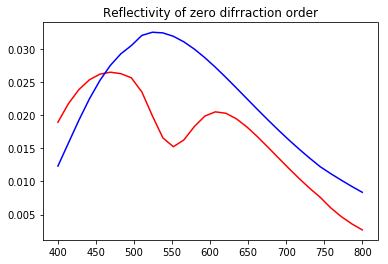

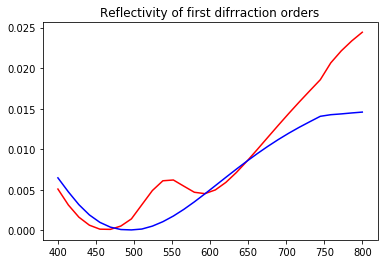

CPU times: user 12.3 s, sys: 108 ms, total: 12.4 s
Wall time: 1min 27s


In [46]:
%%time

n_terms = 30
q_1 = get_Q_matrix(n_0**2,0,0,0,n_0**2,0,0,0,n_0**2,period,n_terms,fill_factor)
values = np.array(list(pool.map(wvDep,points)))

specular = (values[:,0,0]+values[:,1,0])/2
diffraction = (values[:,0,1]+values[:,1,1] + values[:,0,4]+values[:,1,4])/4
plt.title("Reflectivity of zero difrraction order")
plt.plot(points,values[:,0,0],'r-', points, values[:,1,0], 'b-')
plt.show()

plt.title("Reflectivity of first difrraction orders")
plt.plot(points,values[:,0,1],'r-',points,values[:,1,1],'b-')
plt.show()

In [50]:
@jit
def jit_get_C_matrix_anal(period, n_terms, fill_factor, e_0, e_1):
    arr = np.zeros((2 * n_terms + 1, 2 * n_terms + 1), dtype=np.complex128)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr[i, j] = toeplitz_term_anal(fill_factor, period, i-j, e_0, e_1)
    return arr


@njit(["complex128(float64,float64,int32,complex128,complex128)"])
def toeplitz_term_anal(fill_factor, period, order, e_0, e_1):
    if e_0 == 0:
        return 0
    if order == 0:
        return fill_factor * (e_0 - e_1) + e_1
    else:
        return fill_factor * (e_0 - e_1) * np.sinc(fill_factor * order)
    

@jit
def get_Q_matrix_anal(perm,perm2, period, n_terms, fill_factor):
    e_11 = perm[0]
    e_12 = perm[1]
    e_13 = perm[2]
    e_21 = perm[3]
    e_22 = perm[4]
    e_23 = perm[5]
    e_31 = perm[6]
    e_32 = perm[7]
    e_33 = perm[8]

    q_22 = np.linalg.inv(jit_get_C_matrix_anal(period, n_terms, fill_factor, 1 / e_22, 1/perm2)) 
    q_12 = jit_get_C_matrix_anal(period, n_terms, fill_factor, e_12 / e_22, 0) * q_22
    q_21 = q_22 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_21 / e_22, 0)
    q_23 = q_22 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_23 / e_22, 0)
    q_32 = jit_get_C_matrix_anal(period, n_terms, fill_factor, e_32 / e_22, 0) * q_22
    q_11 = jit_get_C_matrix_anal(period, n_terms, fill_factor, (e_11 - e_12 * e_21 / e_22),
                                 1/perm2) + q_12 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_21 / e_22, 0)
    q_33 = jit_get_C_matrix_anal(period, n_terms, fill_factor, (e_11 - e_12 * e_21 / e_22),
                                 1/perm2) + q_32 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_23 / e_22, 0)
    q_13 = jit_get_C_matrix_anal(period, n_terms, fill_factor, (e_13 - e_21 * e_23 / e_22),
                                 0) + q_12 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_23 / e_22, 0)
    q_31 = jit_get_C_matrix_anal(period, n_terms, fill_factor, (e_31 - e_32 * e_21 / e_22),
                                 0) + q_32 * jit_get_C_matrix_anal(period, n_terms, fill_factor, e_21 / e_22, 0)
    return np.matrix(q_11), np.matrix(q_12), np.matrix(q_13), np.matrix(q_21), np.matrix(q_22), np.matrix(q_23), np.matrix(q_31), np.matrix(q_32), np.matrix(q_33)


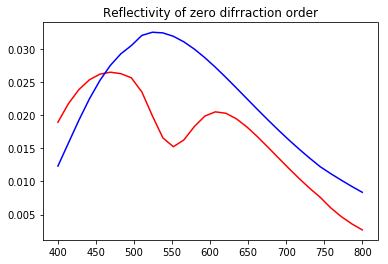

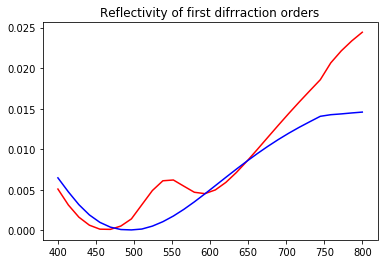

CPU times: user 1.75 s, sys: 207 ms, total: 1.96 s
Wall time: 3.71 s


In [51]:
%%time

q_1 = get_Q_matrix_anal([n_0**2,0,0,0,n_0**2,0,0,0,n_0**2],1,period,n_terms,fill_factor)
values = np.array(list(pool.map(wvDep_anal,points)))

specular = (values[:,0,0]+values[:,1,0])/2
diffraction = (values[:,0,1]+values[:,1,1] + values[:,0,4]+values[:,1,4])/4
plt.title("Reflectivity of zero difrraction order")
plt.plot(points,values[:,0,0],'r-', points, values[:,1,0], 'b-')
plt.show()

plt.title("Reflectivity of first difrraction orders")
plt.plot(points,values[:,0,1],'r-',points,values[:,1,1],'b-')
plt.show()

In [30]:
%timeit get_Q_matrix_anal([n_0**2,0,0,0,n_0**2,0,0,0,n_0**2],period,n_terms,fill_factor)

534 µs ± 24 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit get_Q_matrix(n_0**2,0,0,0,n_0**2,0,0,0,n_0**2,period,n_terms,fill_factor)

4.09 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%load_ext line_profiler

In [752]:
@njit(["complex128[:,:](complex128[:,:],complex128[:,:],complex128[:,:],complex128[:,:])"])
def get_block(a,b,c,d):
    arr = np.empty((2*a.shape[0],2*a.shape[0]),dtype=np.complex128)
    half_len = int(arr.shape[0]/2)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i < arr.shape[0]/2 and j < arr.shape[1]/2:
                arr[i,j] = a[i,j]
            elif i >= arr.shape[0]/2 and j < arr.shape[1]/2:
                arr[i,j] = c[i-half_len,j]
            elif i < arr.shape[0]/2 and j >= arr.shape[1]/2:
                arr[i,j] = b[i,j-half_len]
            elif i >= arr.shape[0]/2 and j >= arr.shape[1]/2:
                arr[i,j] = d[i-half_len,j-half_len]
    return arr

a = np.ones((3,3),dtype=complex)
b = 2*np.ones((3,3),dtype=complex) 
c = 3*np.ones((3,3),dtype=complex)
d = 4*np.ones((3,3),dtype=complex)

@njit
def get_zeros(dim):
    arr = np.empty((dim,dim))
    for i in range(dim):
        for j in range(dim):
            arr[i,j] = 0
    return arr

def get_periodic_layer_T_P_aniso_new(period, toeplitz_matrix, n_terms, angle,
                                     incidence_plane_angle, wv, n_0, width):
    c_11 = toeplitz_matrix[0]
    c_12 = toeplitz_matrix[1]
    c_13 = toeplitz_matrix[2]
    c_21 = toeplitz_matrix[3]
    c_22 = toeplitz_matrix[4]
    c_23 = toeplitz_matrix[5]
    c_31 = toeplitz_matrix[6]
    c_32 = toeplitz_matrix[7]
    c_33 = toeplitz_matrix[8]
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.matrix(np.identity(2 * n_terms + 1))
    o = np.matrix(np.zeros((2 * n_terms + 1, 2 * n_terms + 1)))
    i = np.matrix(np.identity(2 * n_terms + 1))
    g = np.matrix(np.block(
        [[-a * c_33 ** -1 * c_31, i - a * c_33 ** -1 * a, -a * c_33 ** -1 * c_32, a * c_33 ** -1 * b],
         [-b ** 2 + c_11 - c_13 * c_33 ** -1 * c_31, -c_13 * c_33 ** -1 * a, b * a + c_12 - c_13 * c_33 ** -1 * c_32,
          c_13 * c_33 ** -1 * b],
         [-b * c_33 ** -1 * c_31, -b * c_33 ** -1 * a, -b * c_33 ** -1 * c_32, b * c_33 ** -1 * b - i],
         [-a * b - c_21 + c_23 * c_33 ** -1 * c_31, c_23 * c_33 ** -1 * a, a ** 2 - c_22 + c_23 * c_33 ** -1 * c_32,
          -c_23 * c_33 ** -1 * b]]))
    gamma, v = np.linalg.eig(g)
    t, p = getLayerMatrix_ordered(gamma, v, width, wv)
    return  p

In [58]:
@njit
def jit_get_B_matrix(n_terms, wv, period, b0):
    array = np.zeros((2 * n_terms + 1, 2 * n_terms + 1),dtype=np.complex128)
    for i in prange(array.shape[0]):
        for j in prange(array.shape[1]):
            if ((i - j) == 0):
                temp = i - n_terms
                array[i,j] = b0 + wv * temp / period
    return array

def jit_get_periodic_layer_T_P_aniso_new(period, toeplitz_matrix, n_terms, angle,
                                     incidence_plane_angle, wv, n_0, width):
    c_11 = toeplitz_matrix[0]
    c_12 = toeplitz_matrix[1]
    c_13 = toeplitz_matrix[2]
    c_21 = toeplitz_matrix[3]
    c_22 = toeplitz_matrix[4]
    c_23 = toeplitz_matrix[5]
    c_31 = toeplitz_matrix[6]
    c_32 = toeplitz_matrix[7]
    c_33 = toeplitz_matrix[8]
    b0 = n_0 * np.sin(np.deg2rad(angle)) * np.cos(np.deg2rad(incidence_plane_angle))
    b = jit_get_B_matrix(n_terms, wv, period, b0)
    a = n_0 * np.sin(np.deg2rad(incidence_plane_angle)) * np.identity(2 * n_terms + 1)
    o = get_zeros(2 * n_terms + 1)
    i = np.identity(2 * n_terms + 1)
    g_1 = get_block(-a * c_33 ** -1 * c_31, i - a * c_33 ** -1 * a,-b ** 2 + c_11 - c_13 * c_33 ** -1 * c_31, -c_13 * c_33 ** -1 * a)
    g_2 = get_block(-a * c_33 ** -1 * c_32, a * c_33 ** -1 * b, b * a + c_12 - c_13 * c_33 ** -1 * c_32, c_13 * c_33 ** -1 * b)
    g_3 = get_block(-b * c_33 ** -1 * c_31, -b * c_33 ** -1 * a,-a * b - c_21 + c_23 * c_33 ** -1 * c_31, c_23 * c_33 ** -1 * a)
    g_4 = get_block(-b * c_33 ** -1 * c_32, b.dot(np.linalg.inv(c_33)).dot(b) - i, a ** 2 - c_22 + c_23 * c_33 ** -1 * c_32, -c_23 * c_33 ** -1 * b)
    g = get_block(g_1,g_2,g_3,g_4)
    gamma, v = np.linalg.eig(g)
    t, p = jit_getLayerMatrix_ordered(gamma, v, width, wv)
    return  p
    

@njit(["(complex128[:],complex128[:,:],float32,float32)"],parallel=True)
def jit_getLayerMatrix_ordered(gamma, v, width, wv):
    
    limit_value = 0.000000000001
    t = np.zeros((gamma.shape[0],gamma.shape[0]),dtype=np.complex128)
    p = np.zeros((gamma.shape[0],gamma.shape[0]),dtype=np.complex128)
    up = 0
    down = 0
    for x in prange(gamma.shape[0]): 
        if (np.abs(np.imag(gamma[x])) < limit_value):
            if (np.real(gamma[x]) < 0):
                t[:, up] = v[:, up+down]
                p[up,up] = np.exp(1j * x * width * 2 * np.pi / wv)
                up += 1
            else:
                t[:, down + int(gamma.shape[0]/2)] = v[:, up+down]
                p[down + int(gamma.shape[0]/2),down + int(gamma.shape[0]/2)] = np.exp(-1j * x * width * 2 * np.pi / wv)
                down += 1
        elif (np.imag(gamma[x]) < 0):
            t[:, down + int(gamma.shape[0]/2)] = v[:, up+down]
            p[down + int(gamma.shape[0]/2),down + int(gamma.shape[0]/2)] = np.exp(1j * x * width * 2 * np.pi / wv)
            down += 1
        else:
            t[:, up] = v[:, up+down]
            p[up,up] = np.exp(1j * x * width * 2 * np.pi / wv)
            up += 1
    if down != up:
        raise Exception("Ordering of modes failed!")
    return t,p


In [62]:
q_1 = get_Q_matrix_anal([n_0**2,0,0,0,n_0**2,0,0,0,n_0**2],1,period,1,fill_factor)
t1 = get_periodic_layer_T_P_aniso_new(period,q_1,1,angle,0,400,n_air,width)
t2 = jit_get_periodic_layer_T_P_aniso_new(period,q_1,1,angle,0,400,n_air,width)
a = np.abs(t2-t1)
a[a>0.0001]

array([1.03392289, 0.37984142, 0.45037735, 0.26267192, 0.45037735,
       0.37984142, 0.42802303, 1.36991436, 0.42802303, 0.46620705,
       0.26267192, 0.37984142, 0.7522699 , 0.26267192, 0.45037735,
       0.37984142, 0.38185633, 0.3753794 , 0.54512406, 0.38185633,
       0.54512406, 0.3753794 , 0.62223363, 0.46073048, 0.62223363,
       0.46073048, 0.38185633, 0.3753794 , 0.54512406, 0.38185633,
       0.54512406, 0.3753794 , 0.25766265, 0.02364688, 1.        ,
       0.25708283, 0.01849139, 0.64757613, 1.        , 0.64757613,
       0.25657526, 1.        , 0.01727598, 0.25699827, 0.96215724,
       0.06478492, 0.96374351, 0.76200076, 0.76200076, 0.96623494,
       0.08867582, 0.96406062, 0.06934271, 0.9557161 , 0.04612653,
       0.72758102, 1.        , 1.55529317, 0.72758102, 1.82961572,
       1.        ])

In [402]:
%timeit jit_getLayerMatrix_ordered(gamma, v, width, 500)

124 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [403]:
%timeit getLayerMatrix_ordered(gamma, v, width, 500)

2.22 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [734]:
%timeit jit_get_periodic_layer_T_P_aniso_new(period,q_1,n_terms,angle,0,500,n_air,width)

19.9 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [651]:
%timeit get_periodic_layer_T_P_aniso_new(period,q_1,n_terms,angle,0,500,n_air,width)

24 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
